In [1]:
import pandas as pd
import numpy as np

In [3]:
# Settings
start_date = pd.to_datetime("2020-01-01")
end_date = pd.to_datetime("2024-12-31")
face_value = 100
fluctuation = 0.01  # 1% price fluctuation allowance
save_path = "../data/"


In [31]:
data_full = pd.read_csv('../data/rates.csv')
data_full.describe()
data = data_full.copy()

In [32]:
treasuries_full = pd.read_csv('../data/treasury_prices.csv')
treasuries = treasuries_full[['TCUSIP', 'CALDT', 'TDYLD', 'TMATDT', 'TCOUPRT', 'TFCPDT', 'TNIPPY', 'TDNOMPRC']]
treasuries.rename(columns={'CALDT': 'Date', 'TDYLD': 'Yield', 'TMATDT': 'Maturity_Date',
                           'TCOUPRT': 'Coupon_Rate', 'TFCPDT': 'First_Coupon_Date', 'TNIPPY': 'Payment_Freq', 'TDNOMPRC': 'Full_Price'}, inplace=True)
treasuries.loc[:, 'Maturity'] = (pd.to_datetime(treasuries['Maturity_Date']) - pd.to_datetime(treasuries['Date'])).dt.days / 365.25


/var/folders/hw/dfkspcjj1bv53cx3_42lwrtc0000gn/T/ipykernel_7327/2396613984.py:1: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  treasuries_full = pd.read_csv('../data/treasury_prices.csv')
/var/folders/hw/dfkspcjj1bv53cx3_42lwrtc0000gn/T/ipykernel_7327/2396613984.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treasuries.rename(columns={'CALDT': 'Date', 'TDYLD': 'Yield', 'TMATDT': 'Maturity_Date',
/var/folders/hw/dfkspcjj1bv53cx3_42lwrtc0000gn/T/ipykernel_7327/2396613984.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

# Interpolate the yield curve 


In [33]:
key_rates = data.loc[:, ['date', 
                         'sofr',
                         'dgs1mo', 
                        'dgs3mo', 
                        'dgs6mo', 
                        'dgs1', 
                        'dgs2', 
                        'dgs3', 
                        'dgs5', 
                        'dgs7', 
                        'dgs10', 
                        'dgs20', 
                        'dgs30']] 
key_rates.columns = ['date', 1/365, 0.0833, 0.25, 0.5, 1, 2, 3, 5, 7, 10, 20, 30]

key_rates.dropna(inplace=True, axis=0)
key_rates.loc[:, 'date'] = pd.to_datetime(key_rates['date'], format='%Y-%m-%d')
key_rates.set_index('date', inplace=True)
key_rates = key_rates.resample('Q').last()
key_rates = key_rates[(key_rates.index >= start_date) & (key_rates.index <= end_date)]
key_rates.index = key_rates.index.date
key_rates /= 100  # Convert from percentage to decimal

/Users/macaulay/Library/Caches/pypoetry/virtualenvs/yield-curve-interpolation-R19XYUHD-py3.13/lib/python3.13/site-packages/pandas/core/indexes/base.py:7654: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)
/var/folders/hw/dfkspcjj1bv53cx3_42lwrtc0000gn/T/ipykernel_7327/2217118925.py:19: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  key_rates = key_rates.resample('Q').last()


In [34]:
treasuries.loc[:, 'Date'] = pd.to_datetime(treasuries['Date'], format='%Y-%m-%d').dt.date
treasuries.loc[:, 'Maturity_Date'] = pd.to_datetime(treasuries['Maturity_Date'], format='%Y-%m-%d').dt.date
treasuries.loc[:, 'First_Coupon_Date'] = pd.to_datetime(treasuries['First_Coupon_Date'], format='%Y-%m-%d').dt.date

In [35]:
# Calculate discount factors
key_dfs = pd.DataFrame(index=key_rates.index, columns=key_rates.columns)
for col in key_rates.columns:
    key_dfs[col] = np.exp(-key_rates[col] * col)

In [36]:
from yield_curve_interpolation import (syreg_interpolation, 
                                       linear_interpolation, 
                                       cubic_spline_interpolation,
                                       monotone_convex_interpolation,
                                       Nelson_Siegel_interpolation,
                                       Svensson_interpolation)

from yield_curve_interpolation.pricing import bond

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [37]:
def one_load(rates_row, dfs_row, year_, target_maturities, date_):

    results = []

    results.append(("Syreg_Yield", syreg_interpolation(rates_row, year_, 'yield', 'yield')(target_maturities)))
    results.append(("Linear", linear_interpolation(dfs_row, year_)(target_maturities)))

    results.append(("Cubic_Spline", cubic_spline_interpolation(rates_row, year_)(target_maturities)))

    results.append(("Nelson_Siegel", Nelson_Siegel_interpolation(rates_row, year_)(target_maturities)))

    results.append(("Svensson", Svensson_interpolation(rates_row, year_)(target_maturities)))

    results.append(("Monotone_Convex", monotone_convex_interpolation(rates_row, year_)(target_maturities)))

    print(f"Completed interpolations for date {date_}")

    return [(date_, name, arr) for name, arr in results]


## Positivity and non-increasing of Discount Factors

In [38]:
def one_load_curve_interpolation(rates, dfs, dates, year_, target_maturities) -> list:

    rate_arr = rates.to_numpy()
    df_arr   = dfs.to_numpy()
    date_arr = dates.to_numpy()

    for i in range(len(dates)):
        yield_rates = rate_arr[i, :]
        dfs_rates   = df_arr[i, :]

        yield_curve_results = one_load(yield_rates, dfs_rates, year_, target_maturities, date_arr[i])

        if i == 0:
            curve_results = yield_curve_results
        else:
            curve_results.extend(yield_curve_results)

        print(f"Processed date {date_arr[i]} ({i+1}/{len(dates)})")

    return curve_results
    

In [39]:
# Normal interpolation
dates = key_rates.index
year_ = key_rates.columns.values.astype(float)


In [40]:

min_ = year_.min()
target_maturities = np.linspace(min_, 30, 1000)  # From 1 day to 30 years


In [ ]:

curve_results = one_load_curve_interpolation(key_rates, key_dfs, dates, year_, target_maturities)


In [14]:
# Leave out one 
curve_results_loo_all = {}


In [ ]:
maturity = year_[0]
print(f"LOOCV for maturity: {maturity} years")
rates_loo = key_rates.drop(columns=[maturity])
dfs_loo = key_dfs.drop(columns=[maturity])
year_loo = rates_loo.columns.values.astype(float)

curve_results_loo = one_load_curve_interpolation(rates_loo, dfs_loo, dates, year_loo, target_maturities)
curve_results_loo_all[maturity] = curve_results_loo



IndexError: index 12 is out of bounds for axis 0 with size 12

In [30]:
# Transform to dataframe
curve_results_loo_df = pd.DataFrame(columns=['Date', 'Method', 'Maturity', 'Yields'])
for maturity in curve_results_loo_all:
    curve_results_loo_maturity = pd.DataFrame(curve_results_loo_all[maturity], columns=['Date', 'Method', 'Yields'])
    curve_results_loo_maturity['Maturity'] = maturity
    curve_results_loo_df = pd.concat([curve_results_loo_df, curve_results_loo_maturity], ignore_index=True)
# Save
curve_results_loo_df.to_csv(save_path + 'curve_results_loo.csv', index=False)


/var/folders/hw/dfkspcjj1bv53cx3_42lwrtc0000gn/T/ipykernel_4879/786749794.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  curve_results_loo_df = pd.concat([curve_results_loo_df, curve_results_loo_maturity], ignore_index=True)


In [41]:
# Add Fluctuation Analysis
curve_results_fluct = {}

In [54]:
maturity = year_[12]
rates_fluct = key_rates.copy()
dfs_fluct = key_dfs.copy()

# Introduce small fluctuation
rates_fluct[maturity] *= (1 + fluctuation)
dfs_fluct[maturity] = np.exp(-rates_fluct[maturity] * maturity)

curve_results_fluct_maturity = one_load_curve_interpolation(rates_fluct, dfs_fluct, dates, year_, target_maturities)
curve_results_fluct[maturity] = curve_results_fluct_maturity

IndexError: index 12 is out of bounds for axis 0 with size 12

In [58]:
# Transform to dataframe
curve_results_fluct_df = pd.DataFrame(columns=['Date', 'Method', 'Yields'])
for maturity in curve_results_fluct:
    curve_results_fluct_maturity = pd.DataFrame(curve_results_fluct[maturity], columns=['Date', 'Method', 'Yields'])
    curve_results_fluct_df = pd.concat([curve_results_fluct_df, curve_results_fluct_maturity], ignore_index=True)
# Save
curve_results_fluct_df.to_csv(save_path + 'curve_results_fluct.csv', index=False)


In [ ]:
# price result
results = pd.DataFrame(columns=['TCUSIP', 'date', 'Market_Price', 
                                'syreg_interpolation_Price(Yield)',
                                'linear_interpolation_Price',
                                'cubic_spline_interpolation_Price',
                                'Nelson_Siegel_interpolation_Price',
                                'Svensson_interpolation_Price',
                                'monotone_convex_interpolation_Price'])
year_ = np.array(key_rates.columns.values, dtype=np.float64)
for date_ in dates:
    print("========================================")
    print(f"Processing date: {date_}")
    rates_row = key_rates.loc[date_].values
    dfs_row = key_dfs.loc[date_].values
    bonds = treasuries[treasuries['Date'] == date_]
    if bonds.empty:
        continue

    # Set up interpolation generators
    sr_yields = syreg_interpolation(rates_row, year_, domain='yield', return_type='yield')
    lin_yields = linear_interpolation(dfs_row, year_)
    cs_yields = cubic_spline_interpolation(rates_row, year_)
    ns_yields = Nelson_Siegel_interpolation(rates_row, year_)
    sv_yields = Svensson_interpolation(rates_row, year_)
    mc_yields = monotone_convex_interpolation(rates_row, year_)

    # Price bonds using different interpolations
    for _, bond1_info in bonds.iterrows():
        bond1 = bond(id=bond1_info['TCUSIP'],
                    face_value=face_value, 
                    coupon_rate=bond1_info['Coupon_Rate'] / 100, 
                    maturity_date=bond1_info['Maturity_Date'], 
                    first_coupon_date=bond1_info['First_Coupon_Date'],
                    payment_freq=bond1_info['Payment_Freq'],
                    today=bond1_info['Date'])
        result_row = {
            'TCUSIP': bond1.id,
            'date': bond1_info['Date'],
            'Market_Price': bond1_info['Full_Price'],
            'syreg_interpolation_Price(Yield)': bond1.calc_price(zero_rates=sr_yields(bond1.maturities), continuous=True),
            'linear_interpolation_Price': bond1.calc_price(zero_rates=lin_yields(bond1.maturities), continuous=True),
            'cubic_spline_interpolation_Price': bond1.calc_price(zero_rates=cs_yields(bond1.maturities), continuous=True),
            'Nelson_Siegel_interpolation_Price': bond1.calc_price(zero_rates=ns_yields(bond1.maturities), continuous=True),
            'Svensson_interpolation_Price': bond1.calc_price(zero_rates=sv_yields(bond1.maturities), continuous=True),
            'monotone_convex_interpolation_Price': bond1.calc_price(zero_rates=mc_yields(bond1.maturities), continuous=True)
        }
        results = pd.concat([results, pd.DataFrame([result_row])], ignore_index=True)

Processing date: 2020-03-31


/Users/macaulay/Library/Caches/pypoetry/virtualenvs/yield-curve-interpolation-R19XYUHD-py3.13/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/var/folders/hw/dfkspcjj1bv53cx3_42lwrtc0000gn/T/ipykernel_66174/1202485042.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([result_row])], ignore_index=True)


Processing date: 2020-06-30


/Users/macaulay/Library/Caches/pypoetry/virtualenvs/yield-curve-interpolation-R19XYUHD-py3.13/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Processing date: 2020-09-30


/Users/macaulay/Library/Caches/pypoetry/virtualenvs/yield-curve-interpolation-R19XYUHD-py3.13/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Processing date: 2020-12-31


/Users/macaulay/Library/Caches/pypoetry/virtualenvs/yield-curve-interpolation-R19XYUHD-py3.13/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Processing date: 2021-03-31


/Users/macaulay/Library/Caches/pypoetry/virtualenvs/yield-curve-interpolation-R19XYUHD-py3.13/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Processing date: 2021-06-30


/Users/macaulay/Library/Caches/pypoetry/virtualenvs/yield-curve-interpolation-R19XYUHD-py3.13/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Processing date: 2021-09-30


/Users/macaulay/Library/Caches/pypoetry/virtualenvs/yield-curve-interpolation-R19XYUHD-py3.13/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Processing date: 2021-12-31


/Users/macaulay/Library/Caches/pypoetry/virtualenvs/yield-curve-interpolation-R19XYUHD-py3.13/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Processing date: 2022-03-31


/Users/macaulay/Library/Caches/pypoetry/virtualenvs/yield-curve-interpolation-R19XYUHD-py3.13/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Processing date: 2022-06-30


/Users/macaulay/Library/Caches/pypoetry/virtualenvs/yield-curve-interpolation-R19XYUHD-py3.13/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Processing date: 2022-09-30


/Users/macaulay/Library/Caches/pypoetry/virtualenvs/yield-curve-interpolation-R19XYUHD-py3.13/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Processing date: 2022-12-31
Processing date: 2023-03-31


/Users/macaulay/Library/Caches/pypoetry/virtualenvs/yield-curve-interpolation-R19XYUHD-py3.13/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Processing date: 2023-06-30


/Users/macaulay/Library/Caches/pypoetry/virtualenvs/yield-curve-interpolation-R19XYUHD-py3.13/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Processing date: 2023-09-30
Processing date: 2023-12-31
Processing date: 2024-03-31
Processing date: 2024-06-30
Processing date: 2024-09-30


/Users/macaulay/Library/Caches/pypoetry/virtualenvs/yield-curve-interpolation-R19XYUHD-py3.13/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Processing date: 2024-12-31


/Users/macaulay/Library/Caches/pypoetry/virtualenvs/yield-curve-interpolation-R19XYUHD-py3.13/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


In [ ]:
# Error analysis
print("========================================")
print("Error Analysis:")

methods = results.columns.difference(['TCUSIP', 'date', 'Market_Price'])
for method in methods:
    mae = np.mean(np.abs(results['Market_Price'] - results[method]))
    rmse = np.sqrt(np.mean((results['Market_Price'] - results[method]) ** 2))
    print(f"{method}: MAE = {mae:.4f}, RMSE = {rmse:.4f}")

Error Analysis:
Nelson_Siegel_interpolation_Price: MAE = 2.7224, RMSE = 7.5510
Svensson_interpolation_Price: MAE = 2.7049, RMSE = 7.5637
cubic_spline_interpolation_Price: MAE = 2.6416, RMSE = 7.6768
linear_interpolation_Price: MAE = 2.6347, RMSE = 7.5773
monotone_convex_interpolation_Price: MAE = 2.6354, RMSE = 7.5989
syreg_interpolation_Price(Yield): MAE = 2.7508, RMSE = 7.6975


In [ ]:
# Save results
curve_results.to_csv(save_path + 'interpolated_yield_curves.csv', index=False)
curve_results_loo_all.to_csv(save_path + 'interpolated_yield_curves_loo.csv', index=False)
curve_results_fluct.to_csv(save_path + 'interpolated_yield_curves_fluctuation.csv', index=False)
results.to_csv(save_path + 'treasurys_pricing_results.csv', index=False)

## Positivity and non-increasing of Discount Factors

In [ ]:
discount_factors_positive = pd.DataFrame(columns=['Date', 'Method'] + target_maturities.tolist())
for idx in range(len(curve_results)):
    discount_factors_positive.loc[idx, 'Date'] = curve_results.iloc[idx]['Date']
    discount_factors_positive.loc[idx, 'Method'] = curve_results.iloc[idx]['Method']
    discount_factors_positive.loc[idx, target_maturities.tolist()] = np.exp(-curve_results.iloc[idx]['Yields'] * target_maturities)



In [ ]:
# Check positivity and non-increasing
positivity_check = {}
for method in discount_factors_positive['Method'].unique():
    df_method = discount_factors_positive[discount_factors_positive['Method'] == method]
    positive = (df_method[target_maturities.tolist()] >= 0).all().all()
    non_increasing = True
    for idx in range(len(df_method)):
        dfs = df_method.iloc[idx][target_maturities.tolist()].values
        if not np.all(np.diff(dfs) <= 0):
            non_increasing = False
            break
    positivity_check[method] = {'Positive': positive, 'Non-Increasing': non_increasing}

In [ ]:

for method, checks in positivity_check.items():
    print(f"Method: {method}, Positive: {checks['Positive']}, Non-Increasing: {checks['Non-Increasing']}")

Method: Syreg_Yield, Positive: True, Non-Increasing: True
Method: Linear, Positive: True, Non-Increasing: True
Method: Cubic_Spline, Positive: True, Non-Increasing: False
Method: Nelson_Siegel, Positive: True, Non-Increasing: False
Method: Svensson, Positive: True, Non-Increasing: False
Method: Monotone_Convex, Positive: True, Non-Increasing: True


## Forward Rates Calculation and Stability Analysis

In [ ]:
from yield_curve_interpolation.utils import spot_to_fwd

## Forward Rates Calculation and Stability Analysis
forward_rates = pd.DataFrame(columns=['Date', 'Method'] + target_maturities[1:].tolist())
for idx in range(len(curve_results)):
    date_ = curve_results.iloc[idx]['Date']
    method_ = curve_results.iloc[idx]['Method']
    spot_rates = curve_results.iloc[idx]['Yields']
    fwd_rates = spot_to_fwd(spot_rates, target_maturities)
    forward_rates.loc[idx, 'Date'] = date_
    forward_rates.loc[idx, 'Method'] = method_
    forward_rates.loc[idx, target_maturities.tolist()] = fwd_rates[1]

In [ ]:
print(forward_rates.head())

         Date         Method  0.032767  0.062794  0.092822  0.122849  \
0  2020-03-31    Syreg_Yield  0.000327  0.000699  0.000944  0.001112   
1  2020-03-31         Linear  0.000514  0.000514  0.000795    0.0014   
2  2020-03-31   Cubic_Spline  0.000272  0.000566   0.00083  0.001065   
3  2020-03-31  Nelson_Siegel  0.000726  0.000769  0.000811  0.000854   
4  2020-03-31       Svensson  0.000399  0.000545  0.000684  0.000817   

   0.152876  0.182903  0.212931  0.242958  ... 29.759782 29.789809 29.819836  \
0  0.001232   0.00132  0.001388  0.001443  ...  0.016707  0.016699   0.01669   
1    0.0014    0.0014    0.0014    0.0014  ...  0.017508  0.017508  0.017508   
2   0.00127  0.001444  0.001588  0.001702  ...  0.010005  0.009919  0.009833   
3  0.000897  0.000939  0.000982  0.001025  ...  0.019065  0.019067   0.01907   
4  0.000942  0.001061  0.001175  0.001282  ...  0.017191  0.017191  0.017191   

  29.849864 29.879891 29.909918 29.939945 29.969973      30.0   0.00274  
0  0.016681 

In [ ]:
# Volatility of Forward Rates
volatility_results = pd.DataFrame(columns=['Method', 'Date', 'Volatility', 'Max_Change'])

for date_ in forward_rates['Date'].unique():
    for method_ in forward_rates['Method'].unique():
        fwd_subset = forward_rates[(forward_rates['Date'] == date_) & (forward_rates['Method'] == method_)]
        if fwd_subset.empty:
            continue
        fwd_values = fwd_subset[target_maturities[1:].tolist()].values.flatten()
        volatility = np.std(np.abs(np.diff(fwd_values)))
        max_change = np.max(np.abs(np.diff(fwd_values)))
        volatility_results = pd.concat([volatility_results, pd.DataFrame([{
            'Method': method_,
            'Date': date_,
            'Volatility': volatility,
            'Max_Change': max_change
        }])], ignore_index=True)
    
print(volatility_results.head())

/var/folders/hw/dfkspcjj1bv53cx3_42lwrtc0000gn/T/ipykernel_66174/2259420580.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  volatility_results = pd.concat([volatility_results, pd.DataFrame([{


          Method        Date  Volatility  Max_Change
0    Syreg_Yield  2020-03-31    0.000019    0.000372
1         Linear  2020-03-31    0.000212    0.005198
2   Cubic_Spline  2020-03-31    0.000029    0.000294
3  Nelson_Siegel  2020-03-31    0.000013    0.000043
4       Svensson  2020-03-31    0.000020    0.000146


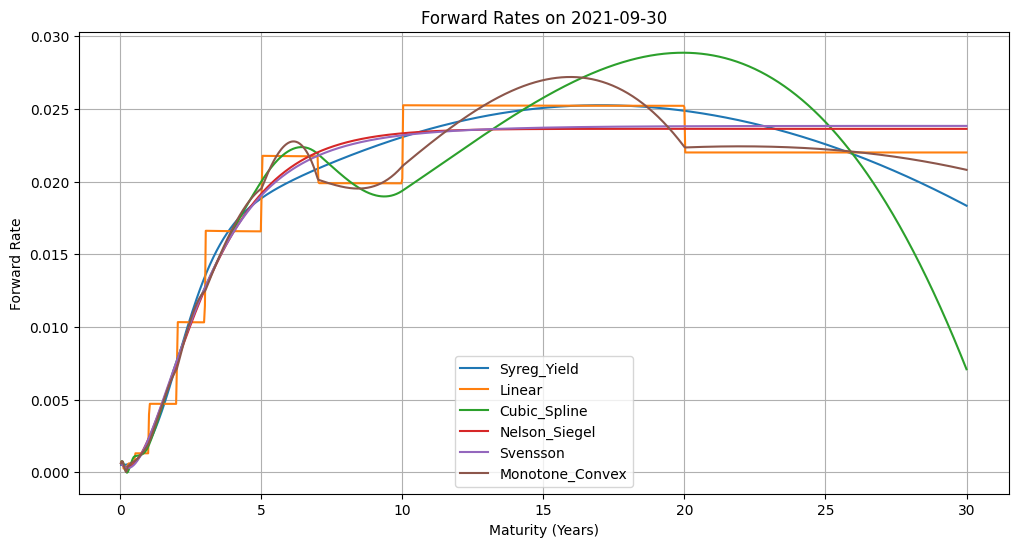

In [ ]:
# Plot forward rates for a sample date

import matplotlib.pyplot as plt
date_ = pd.to_datetime("2021-09-30").date()
df_sample = forward_rates[forward_rates['Date'] == date_]
plt.figure(figsize=(12, 6))
for method in df_sample['Method'].unique():
    df_method = df_sample[df_sample['Method'] == method]
    plt.plot(target_maturities[1:], df_method.iloc[0][target_maturities[1:]], label=method)
plt.title(f'Forward Rates on {df_sample["Date"].iloc[0]}')
plt.xlabel('Maturity (Years)')
plt.ylabel('Forward Rate')
plt.legend()
plt.grid()
# save
plt.savefig(f'../results/graphs/forward_rates_{date_}.png')

plt.show()



## Robustness Checks


In [60]:
curve_results = pd.read_csv(save_path + 'interpolated_yield_curves.csv')
curve_results_loo = pd.read_csv(save_path + 'curve_results_loo.csv')
curve_results_fluct = pd.read_csv(save_path + 'curve_results_fluct.csv')

In [ ]:
robust_results = pd.DataFrame(columns=['Date', 'Method', 'MSE_Fluct', 'MAE_Fluct'])
for date_ in curve_results['Date'].unique():
    curve_date = curve_results[curve_results['Date'] == date_]
    # Further robustness checks can be implemented here
    curve_date_fluct = curve_results_fluct[curve_results_fluct['Date'] == date_]
    curve_date_loo = curve_results_loo[curve_results_loo['Date'] == date_]
    for method in curve_date['Method'].unique():
        curve_method = curve_date[curve_date['Method'] == method]
        curve_method_fluct = curve_date_fluct[curve_date_fluct['Method'] == method]
        curve_method_loo = curve_date_loo[curve_date_loo['Method'] == method]
        yields = curve_method['Yields'].iloc[0].strip("[]").split(" ")
        yields = [float(y) for y in yields if y != '']

        yields_fluct = curve_method_fluct['Yields'].iloc[0].strip("[]").split(" ")
        yields_fluct = [float(y) for y in yields_fluct if y != '']

        yields_loo = curve_method_loo['Yields'].iloc[0].strip("[]").split(" ")
        yields_loo = [float(y) for y in yields_loo if y != '']
        # Compare curve_method and curve_method_fluct for robustness
        mse_fluct = np.mean((np.array(yields) - np.array(yields_fluct)) ** 2)
        mae_fluct = np.mean(np.abs(np.array(yields) - np.array(yields_fluct)))
        mse_loo = np.mean((np.array(yields) - np.array(yields_loo)) ** 2)
        mae_loo = np.mean(np.abs(np.array(yields) - np.array(yields_loo)))
        robust_results = pd.concat([robust_results, pd.DataFrame([{
            'Date': date_,
            'Method': method,
            'MSE_Fluct': mse_fluct,
            'MAE_Fluct': mae_fluct,
            'MSE_LOO': mse_loo,
            'MAE_LOO': mae_loo

        }])], ignore_index=True)

/var/folders/hw/dfkspcjj1bv53cx3_42lwrtc0000gn/T/ipykernel_7327/3875799091.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  robust_results = pd.concat([robust_results, pd.DataFrame([{


Date: 2020-03-31, Method: Syreg_Yield, MSE_Fluct: 0.000000, MAE_Fluct: 0.000107, MSE_LOO: 0.000000, MAE_LOO: 0.000107
Date: 2020-03-31, Method: Linear, MSE_Fluct: 0.000000, MAE_Fluct: 0.000000, MSE_LOO: 0.000000, MAE_LOO: 0.000016
Date: 2020-03-31, Method: Cubic_Spline, MSE_Fluct: 0.000000, MAE_Fluct: 0.000000, MSE_LOO: 0.000000, MAE_LOO: 0.000000
Date: 2020-03-31, Method: Nelson_Siegel, MSE_Fluct: 0.000000, MAE_Fluct: 0.000000, MSE_LOO: 0.000000, MAE_LOO: 0.000037
Date: 2020-03-31, Method: Svensson, MSE_Fluct: 0.000000, MAE_Fluct: 0.000000, MSE_LOO: 0.000000, MAE_LOO: 0.000036
Date: 2020-03-31, Method: Monotone_Convex, MSE_Fluct: 0.000000, MAE_Fluct: 0.000000, MSE_LOO: 0.000000, MAE_LOO: 0.000000
Date: 2020-06-30, Method: Syreg_Yield, MSE_Fluct: 0.000000, MAE_Fluct: 0.000199, MSE_LOO: 0.000000, MAE_LOO: 0.000109
Date: 2020-06-30, Method: Linear, MSE_Fluct: 0.000000, MAE_Fluct: 0.000000, MSE_LOO: 0.000001, MAE_LOO: 0.000041
Date: 2020-06-30, Method: Cubic_Spline, MSE_Fluct: 0.000000, M

In [71]:
print(robust_results[robust_results['Method'] == 'Syreg_Yield'])

           Date       Method     MSE_Fluct  MAE_Fluct       MSE_LOO   MAE_LOO
0    2020-03-31  Syreg_Yield  1.444365e-08   0.000107  1.441844e-08  0.000107
6    2020-06-30  Syreg_Yield  5.603855e-08   0.000199  1.546753e-08  0.000109
12   2020-09-30  Syreg_Yield  1.377767e-08   0.000102           NaN       NaN
18   2020-12-31  Syreg_Yield  1.019169e-08   0.000083  1.068958e-08  0.000088
24   2021-03-31  Syreg_Yield  6.059655e-09   0.000068  2.722347e-08  0.000141
30   2021-06-30  Syreg_Yield  4.741236e-08   0.000187  7.508051e-08  0.000198
36   2021-09-30  Syreg_Yield  6.137776e-08   0.000209  2.202574e-08  0.000119
42   2021-12-31  Syreg_Yield  2.360099e+02   0.487235  3.704732e-04  0.002775
48   2022-03-31  Syreg_Yield  4.987052e-08   0.000193  4.759304e-08  0.000145
54   2022-06-30  Syreg_Yield  6.875149e-05   0.001240  6.874671e-04  0.003323
60   2022-09-30  Syreg_Yield  4.028271e-08   0.000182  8.948953e-05  0.001971
66   2022-12-31  Syreg_Yield  1.893313e-10   0.000002  7.387338e

In [74]:
print(robust_results[robust_results['Date'] == '2021-12-31'])

          Date           Method     MSE_Fluct     MAE_Fluct       MSE_LOO  \
42  2021-12-31      Syreg_Yield  2.360099e+02  4.872351e-01  3.704732e-04   
43  2021-12-31           Linear  2.507010e-14  5.310000e-09  3.157082e-07   
44  2021-12-31     Cubic_Spline  3.679970e-14  2.915000e-08  5.445974e-10   
45  2021-12-31    Nelson_Siegel  1.018802e-13  2.561290e-07  1.594675e-09   
46  2021-12-31         Svensson  1.423635e-13  3.091995e-07  1.559384e-08   
47  2021-12-31  Monotone_Convex  3.129170e-14  7.950000e-09  1.251846e-11   

         MAE_LOO  
42  2.775050e-03  
43  1.887029e-05  
44  3.557900e-06  
45  3.189849e-05  
46  8.595953e-05  
47  1.589700e-07  


In [72]:
for method in robust_results['Method'].unique():
    robust_method = robust_results[robust_results['Method'] == method]
    avg_mse = robust_method['MSE_Fluct'].mean()
    avg_mae = robust_method['MAE_Fluct'].mean()

    print(f"Method: {method}, Average MSE Fluctuation: {avg_mse:.6f}, Average MAE Fluctuation: {avg_mae:.6f}")

Method: Syreg_Yield, Average MSE Fluctuation: 11.801218, Average MAE Fluctuation: 0.024955
Method: Linear, Average MSE Fluctuation: 0.000000, Average MAE Fluctuation: 0.000000
Method: Cubic_Spline, Average MSE Fluctuation: 0.000000, Average MAE Fluctuation: 0.000001
Method: Nelson_Siegel, Average MSE Fluctuation: 0.000000, Average MAE Fluctuation: 0.000046
Method: Svensson, Average MSE Fluctuation: 0.000000, Average MAE Fluctuation: 0.000008
Method: Monotone_Convex, Average MSE Fluctuation: 0.000000, Average MAE Fluctuation: 0.000000


In [64]:
for method in robust_results['Method'].unique():
    robust_method = robust_results[robust_results['Method'] == method]
    avg_mse = robust_method['MSE_LOO'].mean()
    avg_mae = robust_method['MAE_LOO'].mean()
    print(f"Method: {method}, Average MSE LOO: {avg_mse:.6f}, Average MAE LOO: {avg_mae:.6f}")

Method: Syreg_Yield, Average MSE LOO: 0.000064, Average MAE LOO: 0.000640
Method: Linear, Average MSE LOO: 0.001051, Average MAE LOO: 0.000787
Method: Cubic_Spline, Average MSE LOO: 0.000000, Average MAE LOO: 0.000008
Method: Nelson_Siegel, Average MSE LOO: 0.000000, Average MAE LOO: 0.000104
Method: Svensson, Average MSE LOO: 0.000000, Average MAE LOO: 0.000061
Method: Monotone_Convex, Average MSE LOO: 0.000000, Average MAE LOO: 0.000003
